In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
import math

%matplotlib inline

Z = norm.ppf

In [2]:
# CALCULATE HITS FAS AND SO ON

def sdt(subject):
    S = pd.read_csv("C:/Users/HP/Desktop/M-thesis/Behaviour/%s_orig_accu_corrected.csv" %subject)
    S = S.dropna()
    n = [int(S.columns[0]),int(S.columns[1].split('.')[0]),int(S.columns[2].split('.')[0])]
    S =  S.rename(columns ={S.columns[0]: "A", S.columns[1]: "B", S.columns[2]:"C"})
    S.loc[-1] = n
    S.index = S.index + 1  # shifting index
    S = S.sort_index()
    
    right, left = [x for _, x in S.groupby(S['A'] < 6)]

    hits5 = left.loc[(left['A'] == 5) & (left['B'] == 5)]
    hits1 = left.loc[(left['A'] == 1) & (left['B'] == 1)]
    hits10 = right.loc[(right['A'] == 10) & (right['B'] == 10)]
    hits6 = right.loc[(right['A'] == 6) & (right['B'] == 6)]
    hits_left = hits5.shape[0] + hits1.shape[0] 
    hits_right = hits10.shape[0] + hits6.shape[0]
    
    fa5 = left.loc[(left['A'] != 5) & (left['B'] == 5)]
    fa1 = left.loc[(left['A'] != 1) & (left['B'] == 1)]
    fa10 = right.loc[(right['A'] != 10) & (right['B'] == 10)]
    fa6 = right.loc[(right['A'] != 6) & (right['B'] == 6)]
    fas_left = fa5.shape[0] + fa1.shape[0] 
    fas_right = fa10.shape[0] + fa6.shape[0]

    miss5 = left.loc[(left['A'] == 5) & (left['B'] != 5)]
    miss1 = left.loc[(left['A'] == 1) & (left['B'] != 1)]
    miss10 = right.loc[(right['A'] == 10) & (right['B'] != 10)]
    miss6 = right.loc[(right['A'] == 6) & (right['B'] != 6)]
    misses_left = miss5.shape[0] + miss1.shape[0] 
    misses_right = miss10.shape[0] + miss6.shape[0]

    #cr5 = S.loc[(S['A'] != 5) & (S['B'] != 5)]
    
    crs_left = left.shape[0] - (hits_left + fas_left + misses_left)
    crs_right = right.shape[0] - (hits_right + fas_right + misses_right)
    
    out ={"left":[hits_left, misses_left, fas_left, crs_left],
          "right":[hits_right, misses_right, fas_right, crs_right], 
          "tot":[left.shape[0], right.shape[0], S.shape[0]]}
    
    return out 

In [3]:
sublist = ['H07', 'H08', 'H10', 'H11', 'H14', 'H16', 'H17', 'H19', 'H20', 'H21','H22', 'H23', 'H25',
           "P04", "P07", "P08", "P10", "P12", "P13", "P14", "P15", "P16", "P17", "P18", "P19", "P20"]

varlist_l = []
varlist_r = []

for sub in sublist:
    globals() [sub] = sdt(sub)
    varlist_l.append(sdt(sub)["left"])
    varlist_r.append(sdt(sub)["right"])
    

In [4]:
def SDT(hits, misses, fas, crs):
    """ returns a dict with d-prime measures given hits, misses, false alarms, and correct rejections"""
    # Floors an ceilings are replaced by half hits and half FA's
    half_hit = 0.5 / hits + misses
    half_fa = 0.5 / (crs + fas)
 
    # Calculate hit_rate and avoid d' infinity
    hit_rate = hits / (hits + misses)
    if hit_rate == 1: 
        hit_rate = 1 - half_hit
    if hit_rate == 0: 
        hit_rate = half_hit
 
    # Calculate false alarm rate and avoid d' infinity
    fa_rate = fas / (fas + crs)
    if fa_rate == 1: 
        fa_rate = 1 - half_fa
    if fa_rate == 0: 
        fa_rate = half_fa
        
    miss_rate = misses / (hits + misses)
 
    # Return d', beta, c and Ad'
    bbb = {}
    bbb['d']= (Z(hit_rate) - Z(fa_rate)) / math.sqrt(2)
    bbb['c'] = -(Z(hit_rate) + Z(fa_rate)) / 2
    
    #out['Ad'] = norm.cdf(out['d'] / math.sqrt(2))
    #bbb['beta'] = math.exp((Z(fa_rate)**2 - Z(hit_rate)**2) / 2)
    bbb['error'] = [miss_rate, fa_rate]
    
    return bbb


In [5]:
dprimes_left = {}
dprimes_right = {}

for i in range(len(varlist_l)):
    
    dp = SDT(varlist_l[i][0],varlist_l[i][1],varlist_l[i][2],varlist_l[i][3])
    dprimes_left[sublist[i]] = dp
    
for ii in range(len(varlist_r)):
    
    dp = SDT(varlist_r[ii][0],varlist_r[ii][1],varlist_r[ii][2],varlist_r[ii][3])
    dprimes_right[sublist[ii]] = dp

In [25]:
Cleft = {}
Cright = {}

Clp = {}
Crp = {}

for i in range(13):
    Cleft[sublist[i]] = round(dprimes_left[sublist[i]]['c'],4)
    Cright[sublist[i]] = round(dprimes_right[sublist[i]]['c'],4)
    Clp[sublist[i+13]] = round(dprimes_left[sublist[i+13]]['c'],4)
    Crp[sublist[i+13]] = round(dprimes_right[sublist[i+13]]['c'],4)
    

c_left = pd.DataFrame.from_dict(Cleft, orient='index').rename(columns={0:'bias left'})
c_right = pd.DataFrame.from_dict(Cright, orient='index').rename(columns={0:'bias right'})
c_aff = pd.DataFrame.from_dict(Caff, orient='index').rename(columns={0:'bias aff'})
c_unaff = pd.DataFrame.from_dict(Cunaff, orient='index').rename(columns={0:'bias unaff'})


In [26]:
Dleft = {}
Dright = {}

Dlp = {}
Drp = {}

for i in range(13):
    Dleft[sublist[i]] = round(dprimes_left[sublist[i]]['d'],4)
    Dright[sublist[i]] = round(dprimes_right[sublist[i]]['d'],4)
    Dlp[sublist[i+13]] = round(dprimes_left[sublist[i+13]]['d'],4)
    Drp[sublist[i+13]] = round(dprimes_right[sublist[i+13]]['d'],4)

d_left = pd.DataFrame.from_dict(Dleft, orient='index').rename(columns={0:'d-prime left'})
d_right = pd.DataFrame.from_dict(Dright, orient='index').rename(columns={0:'d-prime right'})
d_aff = pd.DataFrame.from_dict(Daff, orient='index').rename(columns={0:'d-prime aff'}).div(math.sqrt(2))
d_unaff = pd.DataFrame.from_dict(Dunaff, orient='index').rename(columns={0:'d-prime unaff'}).div(math.sqrt(2))


In [8]:
ds_p = pd.concat([d_aff, d_unaff], axis=1)
ds_h = pd.concat([d_left, d_right], axis=1)
ds_p['m'] = ds_p.mean(axis=1)
ds_h['m'] = ds_h.mean(axis=1)

crps = ds_p.sort_values(by=['m'])
hv = ds_h.sort_values(by=['m'])

In [9]:
crps_ord = pd.DataFrame.from_dict(crps_ord, orient='index').rename(columns={0:'d-prime',1:'c'})
hv_ord = pd.DataFrame.from_dict(hv_ord, orient='index').rename(columns={0:'d-prime',1:'c'})

[[]]

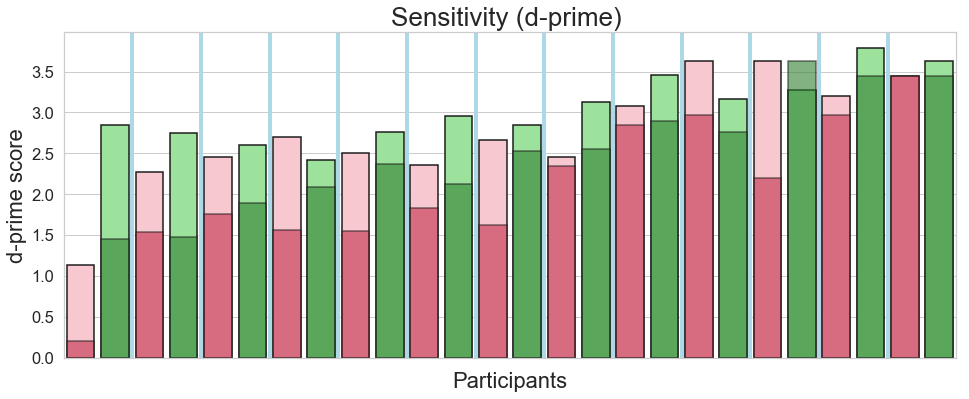

In [10]:
# PLOTS FIGURE 5 A

sns.set(font_scale = 1.5, style="whitegrid")
kwargs = {'alpha':0.6, 'linewidth':1.5, 'edgecolor':'k'}
kwargs2 = {'alpha':1, 'linewidth':1.5, 'edgecolor':'k'}

f = plt.figure(figsize=(16, 6))

clrs_hv = ['pink' if (x == 'l') else 'lightgreen' for x in hv_ord.c ] 
clrs_crps = ['crimson' if (x == 'a') else 'forestgreen' for x in crps_ord.c ] 

f = sns.barplot(x = hv_ord.index, y=abs(hv_ord['d-prime']), data=hv_ord, palette = clrs_hv, **kwargs2)
f = sns.barplot(x = crps_ord.index, y= abs(crps_ord['d-prime']),  data=crps_ord, palette = clrs_crps, **kwargs)

xpoints = [1.5, 3.5, 5.5, 7.5, 9.5 , 11.5, 13.5, 15.5, 17.5, 19.5, 21.5, 23.5]

for p in xpoints:
    plt.axvline(x=p, ymin=0, ymax=4, color = 'lightblue', linewidth=4)

f.set_title('Sensitivity (d-prime) ', fontsize = 26)  
f.set_xlabel('Participants', fontsize = 22)
f.set_ylabel('d-prime score', fontsize = 22)
f.set(xticklabels=[])
#f.set_xlim(-4.5,4.5)


(-4.5, 4.5)

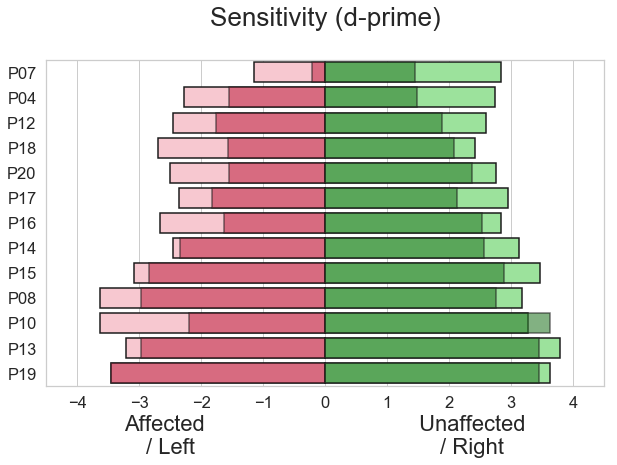

In [11]:
# ALTERNATICE TO FIGURE 5A, orizontal 

sns.set(font_scale = 1.5, style="whitegrid")
kwargs = {'alpha':0.6, 'linewidth':1.5, 'edgecolor':'k'}
kwargs2 = {'alpha':1, 'linewidth':1.5, 'edgecolor':'k'}

f = plt.figure(figsize=(10, 6))

f = sns.barplot(x = -abs(hv['d-prime left']), y= hv.index, data=hv, color = 'pink', **kwargs2)
f = sns.barplot(x = abs(hv['d-prime right']), y= hv.index, data=hv, color = 'lightgreen', **kwargs2)

f = sns.barplot(x = -abs(crps['d-prime aff']), y= crps.index, data=crps, color = 'crimson', **kwargs)
f = sns.barplot(x = abs(crps['d-prime unaff']), y= crps.index, data=crps, color = 'forestgreen', **kwargs)

f.set_title('Sensitivity (d-prime)\n ', fontsize = 26)  
f.set_xlabel('Affected                                   Unaffected\n/ Left                                        / Right', fontsize = 22)
#ax1.set_ylabel('Patient', fontsize = 14)
f.set_xlim(-4.5,4.5)


#f.tight_layout()
#f.savefig('dprimes.png')

Text(0.5, 1.0, '')

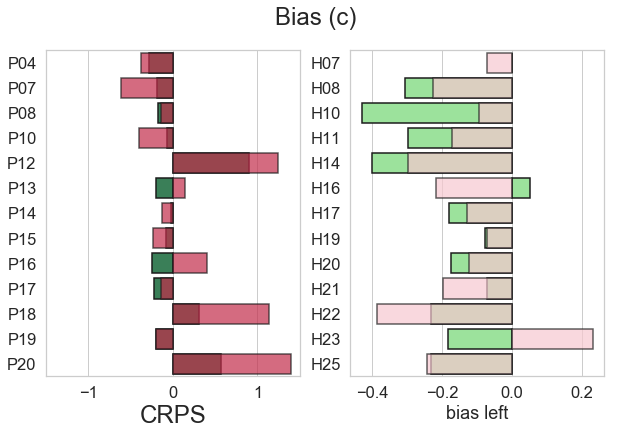

In [12]:
# PLOTS FIGURE 5 B

sns.set(font_scale = 1.5, style="whitegrid")

kwargs = {'alpha':0.7, 'linewidth':1.5, 'edgecolor':'k'}
kwargs2 = {'alpha':1, 'linewidth':1.5, 'edgecolor':'k'}

f = plt.figure(figsize=(10, 6))
gs = f.add_gridspec(1, 2)

f.suptitle('Bias (c)\n ', fontsize = 24)
  
ax1 = f.add_subplot(gs[0, 0])

ax1 = sns.barplot(x = c_unaff['bias unaff'], y= c_unaff.index, data=c_unaff, color = 'seagreen', **kwargs2)
ax1 = sns.barplot(x = c_aff['bias aff'], y= c_aff.index, data=c_aff, color = 'crimson', **kwargs)


ax1.set_title('', fontsize = 26)  
ax1.set_xlim(-1.5,1.5)
ax1.set_xlabel('CRPS', fontsize = 24)


ax2 = f.add_subplot(gs[0, 1])

ax2 = sns.barplot(x = c_right['bias right'], y= c_right.index, data=c_right, color = 'lightgreen', **kwargs2)
ax2 = sns.barplot(x = c_left['bias left'], y= c_left.index, data=c_left, color = 'pink', **kwargs)

ax2.set_title('', fontsize = 26)  


In [14]:
# FANCY RAIN PLOTS 

sns.set(style="whitegrid",font_scale=2)
import matplotlib.collections as clt
import ptitprince as pt

In [27]:
d_left.columns = ['d-score']
d_left['Group'] = 'HV'
d_left['Side'] = 'affected/non-dominant'

d_right.columns = ['d-score']
d_right['Group'] = 'HV'
d_right['Side'] = 'unaffected/dominant'

c_left.columns = ['c-score']
c_left['Group'] = 'HV'
c_left['Side'] = 'affected/non-dominant'

c_right.columns = ['c-score']
c_right['Group'] = 'HV'
c_right['Side'] = 'unaffected/dominant'

d_aff.columns = ['d-score']
d_aff['Group'] = 'CRPS'
d_aff['Side'] = 'affected/non-dominant'

d_unaff.columns = ['d-score']
d_unaff['Group'] = 'CRPS'
d_unaff['Side'] = 'unaffected/dominant'

c_aff.columns = ['c-score']
c_aff['Group'] = 'CRPS'
c_aff['Side'] = 'affected/non-dominant'

c_unaff.columns = ['c-score']
c_unaff['Group'] = 'CRPS'
c_unaff['Side'] = 'unaffected/dominant'

ds = pd.concat([d_left, d_right, d_aff, d_unaff], axis=0)
cs = pd.concat([c_left, c_right, c_aff, c_unaff], axis=0)


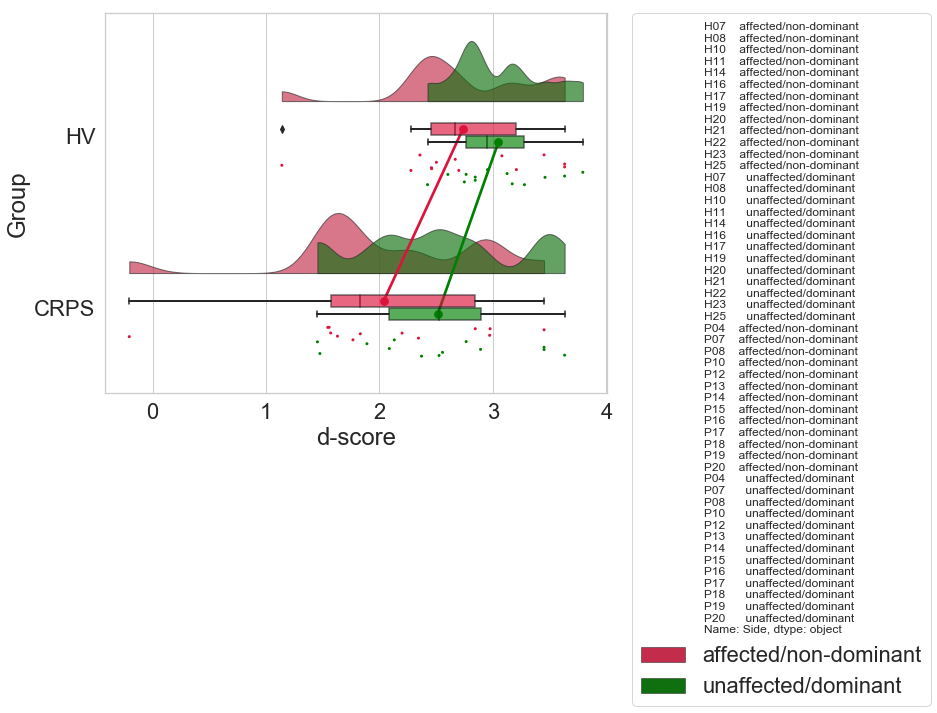

In [45]:
# FIGURE 5 C

ort = "h"; pal = ['crimson','green']; sigma = .2

f, ax = plt.subplots(figsize=(9, 7))

ax = pt.RainCloud(x = ds["Group"], y = ds["d-score"], hue = ds["Side"], data = ds, palette = pal, bw = sigma,
                 width_viol = .7, ax = ax, orient = ort, alpha = .65, dodge = True, pointplot = True, move = .2)


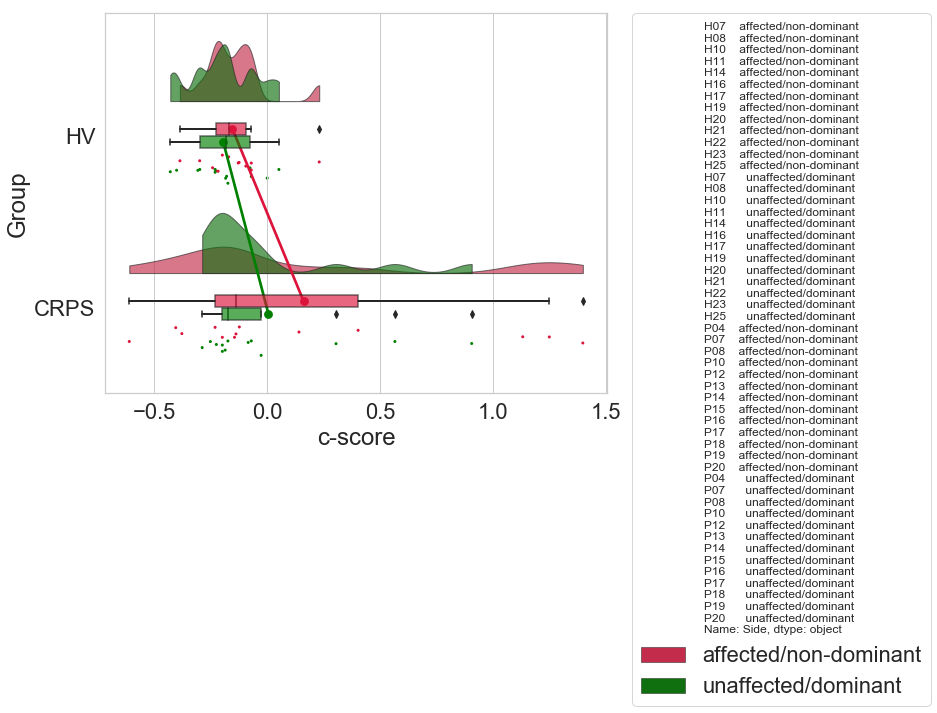

In [42]:
# FIGURE 5 D

ort = "h"; pal = ['crimson','green']; sigma = .2

f, ax = plt.subplots(figsize=(9, 7))

ax = pt.RainCloud(x = cs["Group"], y = cs["c-score"], hue = cs["Side"], data = cs, palette = pal, bw = sigma,
                 width_viol = .7, ax = ax, orient = ort, alpha = .65, dodge = True, pointplot = True, move = .2)

In [ ]:
'''f, ax = plt.subplots(figsize=(7, 5))

ax=pt.half_violinplot( x = dx, y = dy, data = new_d, palette = pal, bw = .2, cut = 0.,
                      scale = "area", width = .6, inner = None, orient = ort)
ax=sns.stripplot( x = dx, y = dy, data = new_d, palette = pal, edgecolor = "white",
                 size = 3, jitter = 1, zorder = 0, orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = new_d, color = "black", width = .15, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = ort)
'''